<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ElasticNet-on-Barclays" data-toc-modified-id="ElasticNet-on-Barclays-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ElasticNet on Barclays</a></span></li></ul></div>

# ElasticNet on Barclays

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import ElasticNet

from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import warnings
import pandas as pd

display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')

In [3]:
FTSE_volatility_df = pd.read_csv('../data/1.1-FTSE_VOL-PRICES_2006-2023.csv')
ticker = 'BARC'

sample_df = FTSE_volatility_df[FTSE_volatility_df.Ticker == ticker]
sample_df = sample_df[sample_df['V^YZ'].notnull()].reset_index(drop=True)
display(sample_df)

,Unnamed: 0,Month,Date,Asset,Currency,PermID,Ticker,RIC,Open,High,...,O_i,u_i,d_i,c_i,V^O,V^C,temp_RS,V^CC,V^RS,V^YZ
0,1934,2006-01-01,2006-01-10,8589934333,GBP,8589934333,BARC,BARC.L,5.631573,5.631573,...,-0.003190,0.000000,-0.013671,-0.011245,0.004509,0.008491,0.000033,0.012363,0.010122,0.010916
1,1935,2006-01-01,2006-01-11,8589934333,GBP,8589934333,BARC,BARC.L,5.618079,5.654063,...,0.008846,0.006385,-0.007232,0.003197,0.004501,0.007798,0.000096,0.011434,0.009964,0.010721
2,1936,2006-01-01,2006-01-12,8589934333,GBP,8589934333,BARC,BARC.L,5.636071,5.694546,...,0.000000,0.010322,-0.003197,0.003187,0.004501,0.007222,0.000094,0.010369,0.010724,0.011302
3,1937,2006-01-01,2006-01-13,8589934333,GBP,8589934333,BARC,BARC.L,5.645067,5.663059,...,-0.001592,0.003182,-0.013638,-0.010413,0.004844,0.007023,0.000087,0.011009,0.011386,0.011978
4,1938,2006-01-01,2006-01-16,8589934333,GBP,8589934333,BARC,BARC.L,5.586592,5.591090,...,0.000000,0.000805,-0.009709,-0.000805,0.004681,0.007145,0.000088,0.010929,0.008922,0.009904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,419657,2023-04-01,2023-04-24,8589934333,GBP,8589934333,BARC,BARC.L,1.523000,1.550299,...,-0.006153,0.017766,-0.001451,0.012398,0.007039,0.009089,0.000115,0.006436,0.012050,0.013684
4368,419658,2023-04-01,2023-04-25,8589934333,GBP,8589934333,BARC,BARC.L,1.535200,1.542400,...,-0.004419,0.004679,-0.017611,-0.013509,0.005085,0.010982,0.000157,0.009484,0.012111,0.013016
4369,419659,2023-04-01,2023-04-26,8589934333,GBP,8589934333,BARC,BARC.L,1.514600,1.544800,...,0.000000,0.019743,-0.011821,0.015722,0.005254,0.013388,0.000405,0.013101,0.014710,0.015477
4370,419660,2023-04-01,2023-04-27,8589934333,GBP,8589934333,BARC,BARC.L,1.562200,1.624746,...,0.015222,0.039257,-0.005263,0.036578,0.009229,0.018782,0.000325,0.027399,0.014964,0.018014


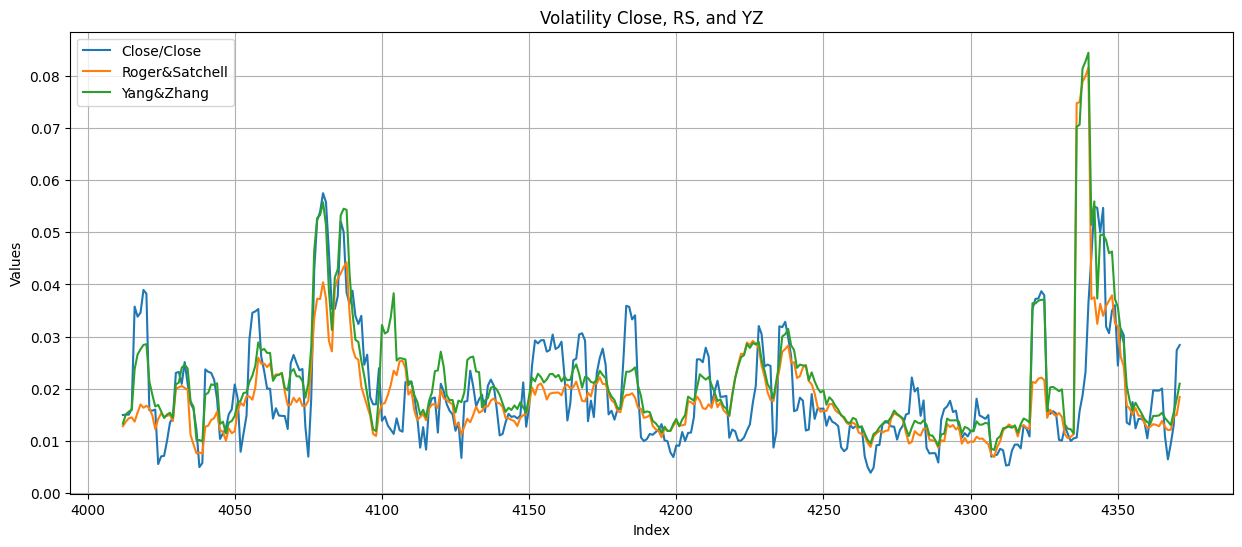

In [4]:
sample_5m = sample_df.iloc[-30*12:, :]

plt.figure(figsize=(15, 6))

# Plot each column
plt.plot(sample_5m['V^CC'], label='Close/Close')
plt.plot(sample_5m['V^RS'], label='Roger&Satchell')
plt.plot(sample_5m['V^YZ'], label='Yang&Zhang')

# Optionally, add grid
plt.grid(True)

# Add legend to distinguish each line
plt.legend()

# Add title and labels
plt.title('Volatility Close, RS, and YZ')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()

---

In [4]:
# Assume you have a DataFrame df with your time series in a column 'volatility'
volatility = sample_5m['V^YZ']

# Create lags for daily, weekly and monthly volatility
volatility_lag_daily = volatility.shift(1)
volatility_lag_weekly = volatility.rolling(5).mean().shift(1)
volatility_lag_monthly = volatility.rolling(22).mean().shift(1)

# Create a DataFrame for the regression
df_regression = pd.DataFrame({
    'volatility': volatility,
    'volatility_lag_daily': volatility_lag_daily,
    'volatility_lag_weekly': volatility_lag_weekly,
    'volatility_lag_monthly': volatility_lag_monthly,
})

df_regression = df_regression.dropna()

In [5]:
test_size = int(df_regression.shape[0]*0.2)

In [6]:
df_train, df_test = df_regression.iloc[:-test_size,], df_regression.iloc[-test_size:,]

In [8]:
y_train = df_train['volatility']

# Define the independent variables
X_train = df_train[['volatility_lag_daily', 'volatility_lag_weekly', 'volatility_lag_monthly']]

# Add a constant to the independent variables matrix

In [9]:
# Train the model
model = ElasticNet(l1_ratio=0.5)  # set l1_ratio to something between 0 and 1. 0.5 gives equal weight to L1 and L2 penalties
model.fit(X_train, y_train)

ElasticNet()

In [10]:
y_test = df_test['volatility']

# Define the independent variables
X_test = df_test[['volatility_lag_daily', 'volatility_lag_weekly', 'volatility_lag_monthly']]

# Add a constant to the independent variables matrix
# X_test = add_constant(X_test)

In [11]:
y_pred = model.predict(X_test)

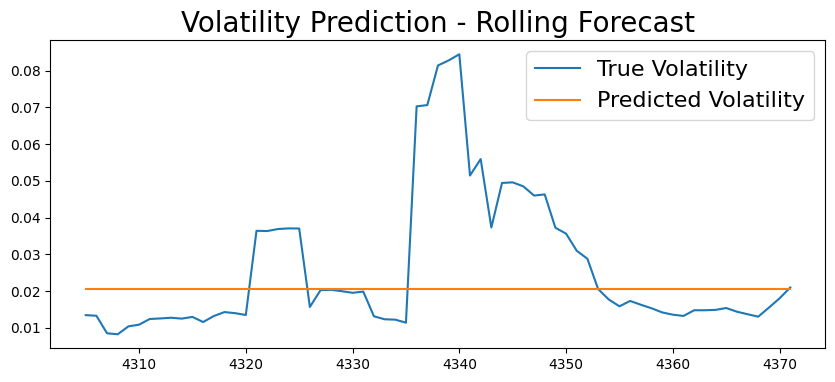

In [17]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(pd.Series(y_pred, index=y_test.index))
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [12]:
mse_million = mean_squared_error(y_test,y_pred)*10**6

In [13]:
GARCH_results = pd.DataFrame({
    'Model':'Heterogeneous AutoRegressive',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(GARCH_results)

,Model,Test Size,MSE^6
0,Heterogeneous AutoRegressive,67,91.82405
